# Описание задачи

Необходимо научиться различать свежие и испорченные фрукты по изображениям.

**Input** — фото фрукта

**Output** — метка "Fresh" или "Rotten"

# Идея решения

Используется подход transfer learning: берём предобученную модель EfficientNetB0, которая умеет извлекать признаки из изображений, и дообучаем её на нашем датасете фруктов.

К выходу EfficientNet добавляется классификационная часть: сначала слой глобального усреднения (Global Average Pooling) превращает карту признаков в вектор, затем полносвязный слой помогает различать свежие и испорченные фрукты.

Для снижения переобучения используется слой Dropout. Финальный слой с сигмоидой выдаёт вероятность того, что фрукт испорчен. Если вероятность > 0.5 — класс Rotten, иначе — Fresh.

# Импорт библиотек и базовые настройки

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

sns.set(style="whitegrid")
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Загрузка датасета

In [ ]:
dataset_path = kagglehub.dataset_download("abdulrafeyyashir/fresh-vs-rotten-fruit-images")
DATASET_PATH = dataset_path + "/Fruit Freshness Dataset/Fruit Freshness Dataset"

Using Colab cache for faster access to the 'fresh-vs-rotten-fruit-images' dataset.


# Индексация данных

Собираем пути к изображениям и формируем список названий классов.

In [ ]:
class_paths, class_labels = [], []
for fruit in os.listdir(DATASET_PATH):
    fruit_path = os.path.join(DATASET_PATH, fruit)
    if os.path.isdir(fruit_path):
        for status in os.listdir(fruit_path):
            status_path = os.path.join(fruit_path, status)
            if os.path.isdir(status_path):
                class_paths.append(status_path)
                class_labels.append(f"{fruit}_{status}")

# Анализ распределения классов

Смотрим, сколько изображений в каждом классе, чтобы проверить баланс.

In [ ]:
class_counts = {label: len(os.listdir(path)) for label, path in zip(class_labels, class_paths)}

/tmp/ipython-input-933921472.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


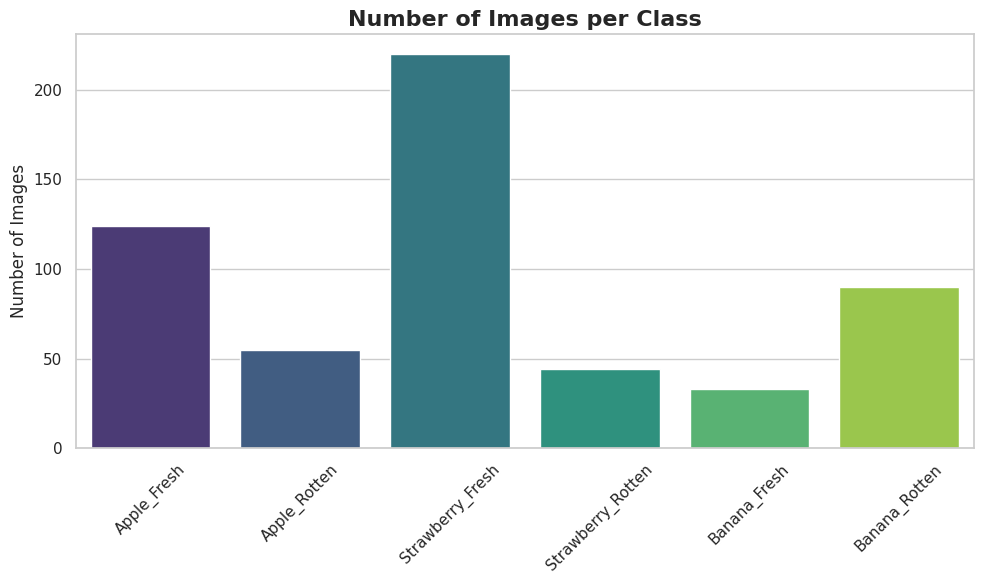

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Number of Images per Class", fontsize=16, fontweight="bold")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Примеры изображений

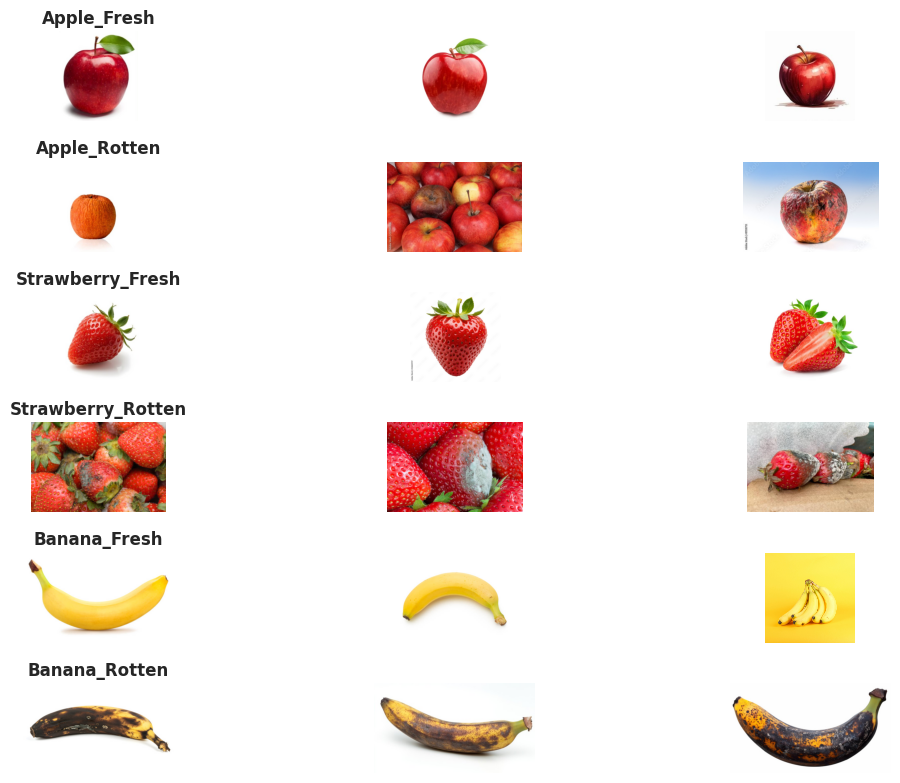

In [ ]:
NUM_IMAGES_PER_CLASS = 3
plt.figure(figsize=(12,8))
for i, (path, label) in enumerate(zip(class_paths, class_labels)):
    img_names = random.sample(os.listdir(path), min(len(os.listdir(path)), NUM_IMAGES_PER_CLASS))
    for j, img_name in enumerate(img_names):
        plt.subplot(len(class_paths), NUM_IMAGES_PER_CLASS, i*NUM_IMAGES_PER_CLASS + j + 1)
        img = Image.open(os.path.join(path, img_name))
        plt.imshow(img)
        plt.axis("off")
        if j == 0:
            plt.title(label, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# Подготовка данных к обучению

Преобразуем метки в бинарные:
- 0 -- свежий фрукт,
- 1 -- испорченный.

Делим данные на
- train -- для обучения,
- val -- для подбора параметров,
- test -- для проверки модели.

In [ ]:
paths, labels = [], []

for path, label in zip(class_paths, class_labels):
    for img_name in os.listdir(path):
        paths.append(os.path.join(path, img_name))
        labels.append(0 if "Fresh" in label else 1)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    paths, labels,
    test_size=0.15, random_state=SEED,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.176,
    random_state=SEED,
    stratify=y_trainval
)

# Проверка форматов изображений

In [ ]:
extensions = set()

for fruit in os.listdir(DATASET_PATH):
    fruit_path = os.path.join(DATASET_PATH, fruit)
    if not os.path.isdir(fruit_path):
        continue
    for status in os.listdir(fruit_path):
        status_path = os.path.join(fruit_path, status)
        if not os.path.isdir(status_path):
            continue
        for file_name in os.listdir(status_path):
            ext = os.path.splitext(file_name)[-1].lower()
            extensions.add(ext)

print("Расширения файлов в датасете:", extensions)

Расширения файлов в датасете: {'.jpg', '.webp', '.jfif', '.png'}


TensorFlow не всегда стабильно работает со всеми форматами, поэтому загружаем изображения через PIL.

# Создание tf.data.Dataset

Загрузка, предобработка и батчинг.

In [ ]:
def load_image(path, label):
    img = Image.open(path.numpy().decode("utf-8")).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = preprocess_input(img)
    return img.astype(np.float32), label

def tf_load_image(path, label):
    img, label = tf.py_function(
        func=load_image, inp=[path, label],
        Tout=[tf.float32, tf.int32]
    )
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label.set_shape([])
    return img, label

def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(tf_load_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds = make_dataset(X_val, y_val, training=False)
test_ds = make_dataset(X_test, y_test, training=False)


# Строим модель

Используем EfficientNetB0 как основу и добавляем классификационную часть.

In [ ]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели


Используем callbacks EarlyStopping, ReduceLROnPlateau и ModelCheckpoint.

Модель обучается на train выборке (train_ds) и проверяется на валидационной выборке (val_ds) после каждой эпохи.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8250 - loss: 0.4285 - val_accuracy: 0.8706 - val_loss: 0.3054 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9735 - loss: 0.0670 - val_accuracy: 0.9059 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9683 - loss: 0.0681 - val_accuracy: 0.9294 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9843 - loss: 0.0470 - val_accuracy: 0.9059 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9853 - loss: 0.0374 - val_accuracy: 0.9412 - val_loss: 0.1818 - learning_rate: 0.0010
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9955 - loss: 0.0318 - val_accuracy: 0.9529 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9896 - loss: 0.0470 - val_accuracy: 

# Оценка модели

Проверяем качество на тестовой выборке.

In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['Fresh','Rotten']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

       Fresh       0.98      1.00      0.99        57
      Rotten       1.00      0.96      0.98        28

    accuracy                           0.99        85
   macro avg       0.99      0.98      0.99        85
weighted avg       0.99      0.99      0.99        85



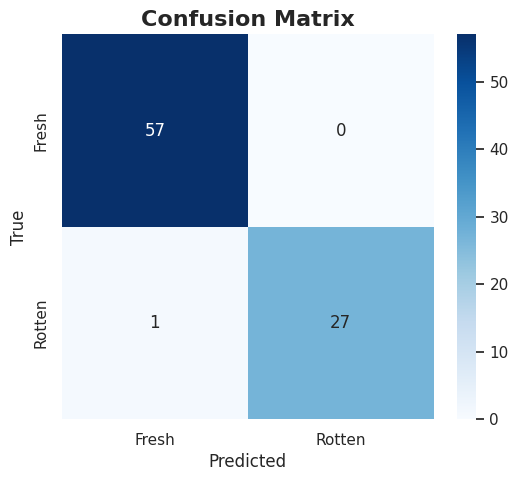

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fresh','Rotten'], yticklabels=['Fresh','Rotten'])
plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# PCA-визуализация данных

Смотрим, как классы располагаются в пространстве признаков.

In [ ]:
X_pca, y_pca = [], []
for path, label in zip(class_paths, class_labels):
    sample_imgs = random.sample(os.listdir(path), min(len(os.listdir(path)), 40))
    for img_name in sample_imgs:
        img = Image.open(os.path.join(path, img_name)).convert('RGB').resize((64,64))
        X_pca.append(np.array(img).flatten())
        y_pca.append(label)

X_pca = np.array(X_pca)
y_pca = np.array(y_pca)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_pca)

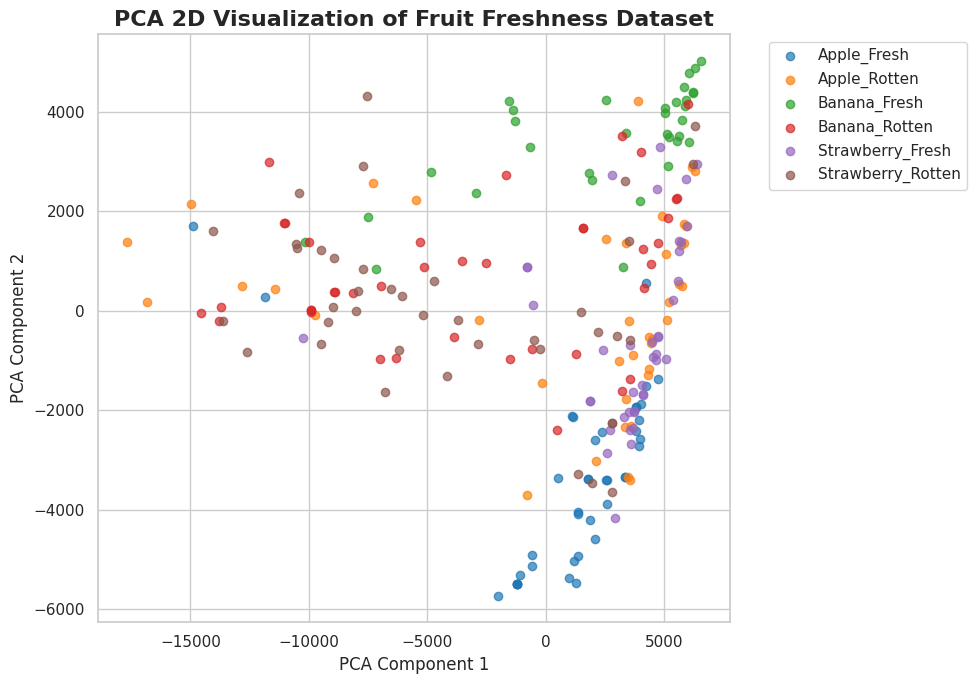

In [ ]:
plt.figure(figsize=(10,7))
palette = sns.color_palette("tab10", n_colors=len(set(y_pca)))
for i, label in enumerate(sorted(set(y_pca))):
    idx = np.where(y_pca == label)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=label, alpha=0.7, color=palette[i])
plt.title("PCA 2D Visualization of Fruit Freshness Dataset", fontsize=16, fontweight="bold")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# Предсказания на случайных изображениях

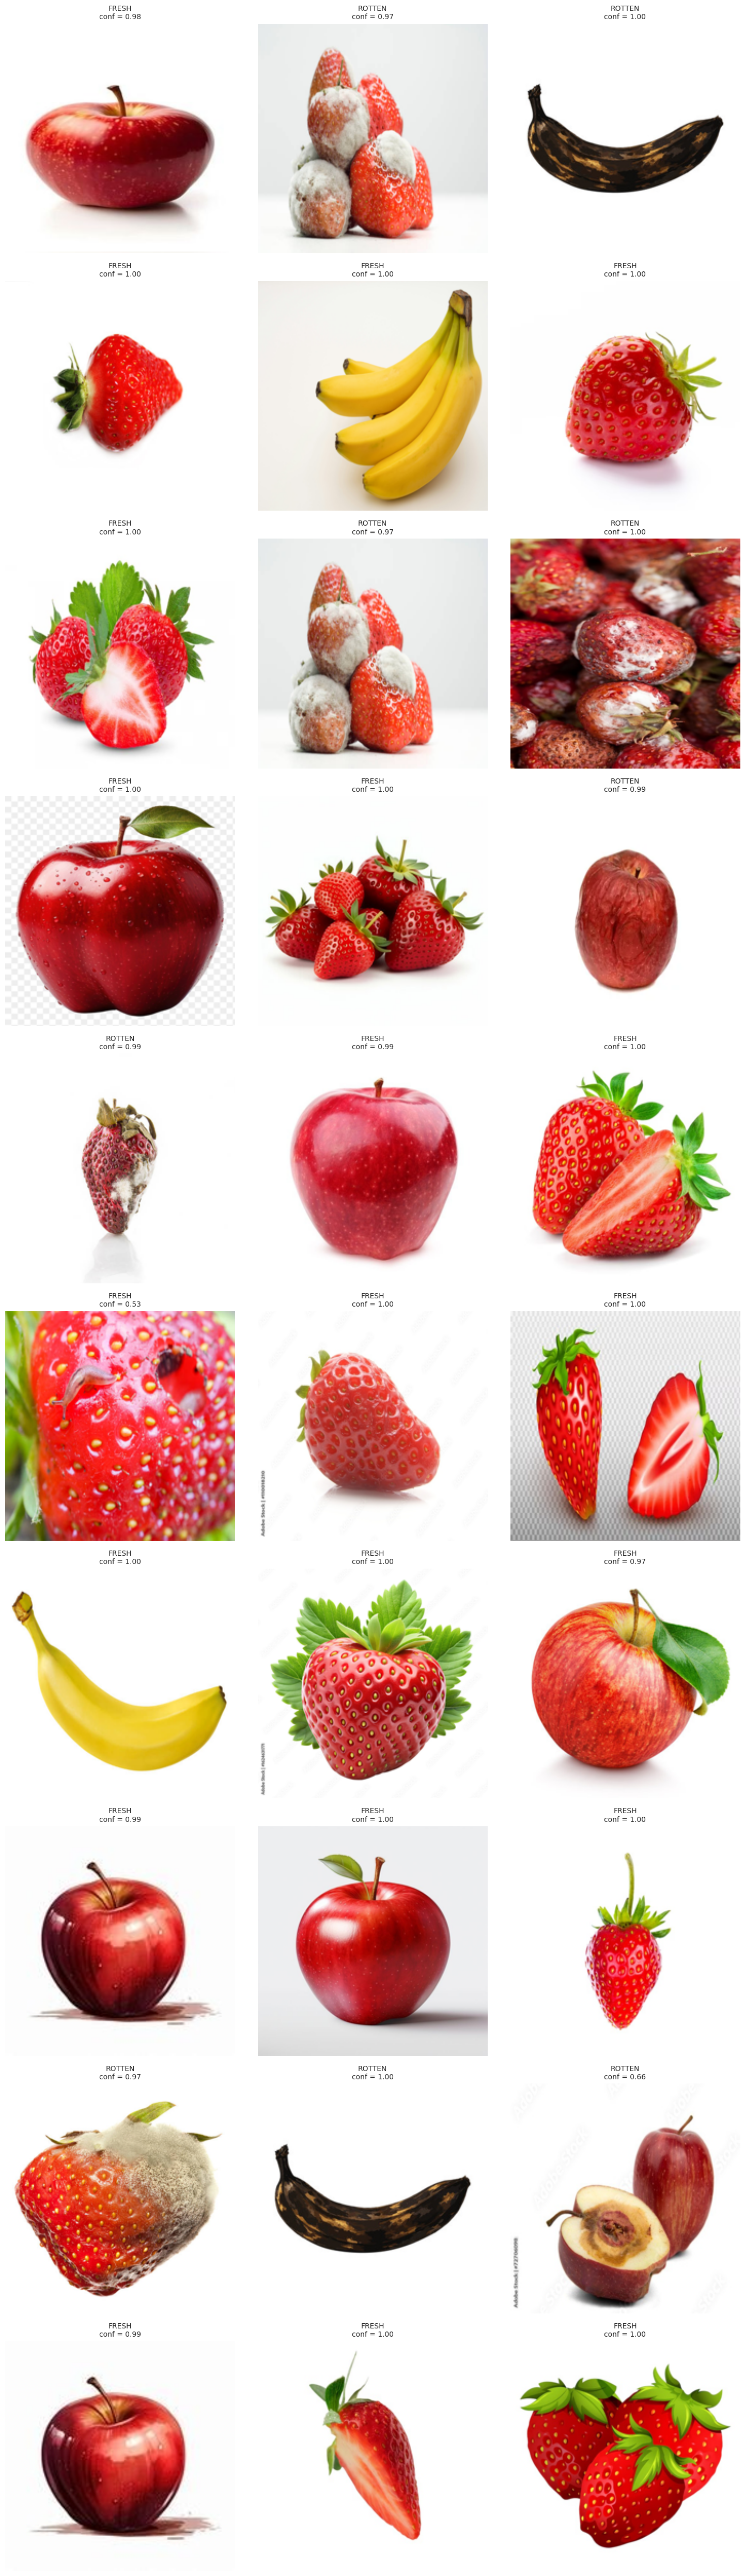

In [17]:
NUM_RANDOM_IMAGES = 30
cols = 3
rows = (NUM_RANDOM_IMAGES + cols - 1) // cols

plt.figure(figsize=(cols*5, rows*5))

for i in range(NUM_RANDOM_IMAGES):
    random_path = random.choice(X_test)

    img_pil = Image.open(random_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img_display = np.array(img_pil)

    img_model = preprocess_input(np.array(img_pil).astype(np.float32))
    img_model = np.expand_dims(img_model, 0)

    prob = model.predict(img_model, verbose=0)[0][0]
    pred_label = "ROTTEN" if prob > 0.5 else "FRESH"
    confidence = prob if prob > 0.5 else 1 - prob

    plt.subplot(rows, cols, i+1)
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"{pred_label}\nconf = {confidence:.2f}", fontsize=10)

plt.tight_layout()
plt.show()